# Градиентный спуск
## Задача поиска оптимальных коэффициентов полиномиальной модели

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

Формируем синтетический датасет на основе полиномиальной функции с добавлением случайного шума ${\epsilon}$:

${f(x) = \sum_{k=0}^{K-1}{w_k \cdot x^k} + \epsilon}$,

где ${w}$ - массив весов размера ${K}$.

Определим полиномиальную функцию, в частном и в общем виде:

In [2]:
def f_trend(x):
    return x**3 - 3*x**2 + 2*x - 5

def f_poly(X, w_coeff):
    Y = np.zeros_like(X)
    for n, x in enumerate(X):
        for idx, w in enumerate(w_coeff.tolist()[0]):
            Y[n] = Y[n] + w * x**idx
    return Y

Сгенерируем синтетический датасет и построим графики.

<function matplotlib.pyplot.show(close=None, block=None)>

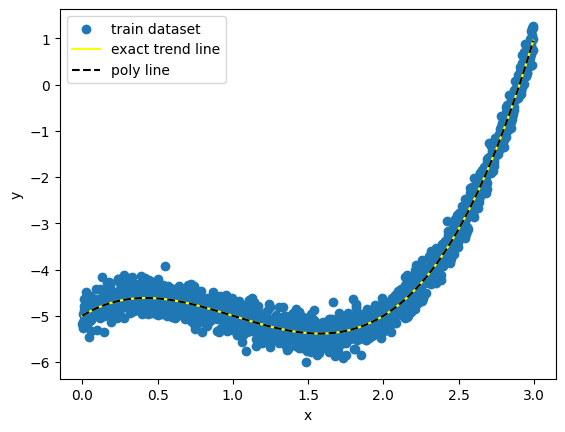

In [3]:
x_min = 0
x_max = 3
N_points = 2000
# Случайный набор X-ов.
X_train = np.random.uniform(low=x_min, high=x_max, size=(N_points,))
# Отклики с добавлением шума.
y_train = f_trend(X_train) + np.random.normal(0,0.2,N_points)

plt.scatter(X_train, y_train)
plt.plot(np.sort(X_train), f_trend(np.sort(X_train)), color='yellow')
plt.plot(np.sort(X_train), f_poly(np.sort(X_train), np.array([[-5, 2, -3, 1]])), '--', color='black')
plt.legend(['train dataset', 'exact trend line', 'poly line'])
plt.xlabel('x')
plt.ylabel('y')
plt.savefig('plots/dataset_plot.png')
plt.show

Функция ошибки:

In [4]:
def loss_func(X, y, w_coeff):
    return np.sum((y - f_poly(X, w_coeff))**2)

Функция поиска параметров методом градиентного спуска.

In [5]:
def model_fit(X_train, y_train, learning_rate, tolerance, batch_ratio, beta):
    t_init = time.time()

    batch_size = int(batch_ratio * len(X_train))
    
    iteration_max = 200000
    
    # Коэффициенты (веса) инициилизируются нулями.
    w_coeff = np.zeros((1,len(learning_rate)))
    
    # Полный буфер коэффициентов.
    w_coeff_buff = w_coeff.copy()

    # Градиенты инициализируются ненулевыми значениями.
    grad = np.ones_like(w_coeff)
    
    # Аккумулятор для фильтра градиента.
    grad_filter = np.zeros_like(grad)
    
    losses = []
    
    for i in range(iteration_max):
        # Выборка случайных элементов (по индексам).
        batch_indices = np.random.choice(len(X_train), size=batch_size, replace=True)
        X_train_batch = [X_train[idx] for idx in batch_indices]
        y_train_batch = [y_train[idx] for idx in batch_indices]
        
        # Элемент оптимизации: ошибку при начальных коэффициентах считаем 1 раз.
        loss_init = loss_func(X_train_batch, y_train_batch, w_coeff)
        for k, w in enumerate(w_coeff.tolist()[0]):
            # Накопление "момента".
            grad_filter[0,k] = beta * grad_filter[0,k] + (1 - beta) * grad[0,k]
            # Шаг градиентного спуска на основе значений градиента, вычисленных на предыдущем шаге.
            w_step = - learning_rate[k] * grad_filter[0,k]

            # Сбрасываем все коэффициенты до исходный значений текущей итерации.
            w_coeff_1 = w_coeff.copy()
            w_coeff_2 = w_coeff.copy()
            
            # Модификация только k-го коэффициента:
            w_coeff_1[0,k] = w + w_step
            w_coeff_2[0,k] = w + 2*w_step

            # Формируем массив значений функции потерь, для вычисления градиента. Массив состоит из 3х элементов.
            loss_func_grad = [loss_init,
                              loss_func(X_train_batch, y_train_batch, w_coeff_1),
                              loss_func(X_train_batch, y_train_batch, w_coeff_2)]
            
            # Массив градиента состоит из 3х чисел с индексами [0, 1, 2]. Берем предпоследнее число.
            grad[0,k] = np.gradient(loss_func_grad, w_step)[1]
            
            # Обновление одного коэффициента в итоговом массиве.
            w_coeff_buff[0,k] = w_coeff_1[0,k].copy()
                
        # Обновление всех коэффициентов.
        w_coeff = w_coeff_buff.copy()
        
        # Вычисление ошибки на полном датасете, при обновленных коэффициентах.
        loss = loss_func(X_train, y_train, w_coeff)
        
        # Накопление ошибки в отдельный массив для дальнейшей визуализации.
        losses.append(loss)
        
        if i % 100 == 0:
            clear_output(wait=True)
            print('Iteration:', i)
            print('Gradient:', np.round(grad[0],4))
            print('Weights:', np.round(w_coeff[0],4))
            print('Loss:', np.round(loss,4))
        
        if (loss < tolerance):
            break
    
    iter_final = i
    fit_time = time.time() - t_init
    return w_coeff, losses, iter_final, fit_time

В ходе обучения заложим среднеквадратическое отклонение до 0.2, т.е. значение, соизмеримое с величиной стандартного отклонения, заданного в шуме синтетического набора данных. Соответствующая сумма квадратов отклонений: (0.2**2 * N_points)=80.

Сначала попробуем обучение на полном датасете, причем learning rate зададим одинаковыми для каждого искомого параметра модели.

Установлено, что большое значение параметра learning rate приводит к неустойчивости решателя. Функция ошибки "улетает" в бесконечность.

Напротив, при малом значении параметра learning rate оптимизация выполняется медленно.

В результате проб подобрано наибольшее значение learning rate, при котором сходимость устойчива (функция ошибки не "улетает" в бесконечность).

In [6]:
# Обучение на полном датасете.
# lr - const.
weights_1, losses_1, iter_final_1, fit_time_1 = model_fit(X_train, y_train,
                                                          learning_rate=5*[1e-7],
                                                          tolerance=(0.2**2 * N_points),
                                                          batch_ratio=1.0,
                                                          beta=0.0)

Iteration: 199900
Gradient: [   1.1207  -18.4978    0.4373  -21.3699 -168.1192]
Weights: [-4.4554 -0.419  -0.1307 -0.272   0.1896]
Loss: 101.5898


В заданное максимальное число итераций не достигнут желаемый уровень ошибки. Маловероятно, что увеличение числа итераций приведет к существенному снижению уровня ошибки.

Поработаем с темпом сходимости. Попробуем задать разный learning rate для параметров модели.

In [7]:
# Обучение на полном датасете.
# lr - индивидуальный для каждого из параметров модели.
weights_2, losses_2, iter_final_2, fit_time_2 = model_fit(X_train, y_train,
                                                          learning_rate=[1e-5, 1e-6, 1e-7, 1e-8, 1e-9],
                                                          tolerance=(0.2**2 * N_points),
                                                          batch_ratio=1.0,
                                                          beta=0.0)

Iteration: 199900
Gradient: [  16.8113    9.3477   -9.1928 -158.3161 -717.3611]
Weights: [-4.6421  0.2902 -0.9175  0.0697  0.1386]
Loss: 89.9658


В заданное максимальное число итераций также не достигнут желаемый уровень ошибки. Но скорость сходимости улучшилась значительно.

Попробуем обучать не на полном датасете, а на случайно выбранных значениях.

В таком случае оказалось, что обучение на батчах устойчиво при бОльших значениях learning rate. Получается, разбиение на батчи не только снижает объем вычислений, но и позволяет улучшить сходимость за счет большего learning rate.

In [8]:
# Обучение на случайных батчах, по 10% датасета.
# lr - индивидуальный для каждого из параметров модели.
weights_3, losses_3, iter_final_3, fit_time_3 = model_fit(X_train, y_train,
                                                          learning_rate=[1e-3, 1e-4, 1e-5, 1e-6, 1e-7],
                                                          tolerance=(0.2**2 * N_points),
                                                          batch_ratio=0.1,
                                                          beta=0.0)

Iteration: 199900
Gradient: [  -6.3103  -11.7027  -29.8161  -77.6567 -196.9583]
Weights: [-4.7844  0.8322 -1.3818  0.1941  0.1312]
Loss: 84.605


Теперь добавим фильтр градиента (momentum) по правилу:

${G_n = \beta G_{n-1} + (1 - \beta)grad_n}$,

${\beta \neq 0}$.

In [9]:
# Обучение на случайных батчах, по 10% датасета.
# lr - индивидуальный для каждого из параметров модели.
# Фильтрация градиента (beta=0.8).
weights_4, losses_4, iter_final_4, fit_time_4 = model_fit(X_train, y_train,
                                                          learning_rate=[1e-3, 1e-4, 1e-5, 1e-6, 1e-7],
                                                          tolerance=(0.2**2 * N_points),
                                                          batch_ratio=0.1,
                                                          beta=0.8)

Iteration: 199900
Gradient: [  5.8746  10.8487  26.5963  67.7651 186.2138]
Weights: [-4.7859  0.8326 -1.3817  0.1942  0.1313]
Loss: 84.543


In [10]:
weights_5, losses_5, iter_final_5, fit_time_5 = model_fit(X_train, y_train,
                                                          learning_rate=[1e-3, 1e-4, 1e-5, 1e-6, 1e-7],
                                                          tolerance=(0.2**2 * N_points),
                                                          batch_ratio=0.1,
                                                          beta=0.4)

Iteration: 199900
Gradient: [ -4.9403  -3.719   -7.1855 -20.9144 -62.257 ]
Weights: [-4.7897  0.8364 -1.381   0.1944  0.1312]
Loss: 84.5832


In [22]:
weights_6, losses_6, iter_final_6, fit_time_6 = model_fit(X_train, y_train,
                                                          learning_rate=[1e-3, 1e-4, 1e-5, 1e-6, 1e-7],
                                                          tolerance=(0.2**2 * N_points),
                                                          batch_ratio=0.2,
                                                          beta=0.0)

Iteration: 199900
Gradient: [  3.0325  29.7427  84.4366 220.4207 574.4253]
Weights: [-4.8173  1.0053 -1.6231  0.3159  0.1114]
Loss: 83.0865


<function matplotlib.pyplot.show(close=None, block=None)>

d:\git\ITMO\ML\ML_2\venv\Lib\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


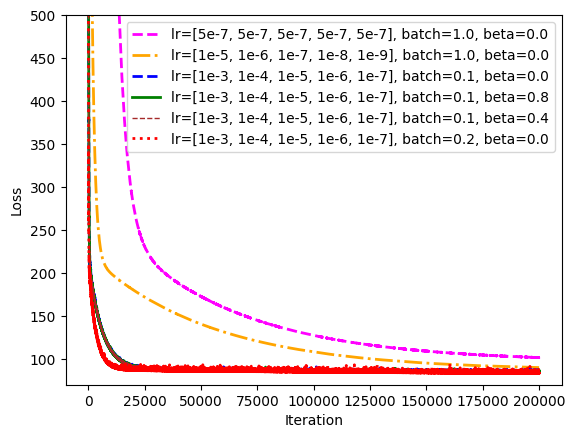

In [23]:
plt.plot(losses_1, color='magenta', linestyle='--', linewidth=2)
plt.plot(losses_2, color='orange', linestyle='-.', linewidth=2)
plt.plot(losses_3, color='blue', linestyle='--', linewidth=2)
plt.plot(losses_4, color='green', linestyle='-', linewidth=2)
plt.plot(losses_5, color='brown', linestyle='--', linewidth=1)
plt.plot(losses_6, color='red', linestyle=':', linewidth=2)
plt.ylim(70,500)
plt.legend(['lr=[5e-7, 5e-7, 5e-7, 5e-7, 5e-7], batch=1.0, beta=0.0',
            'lr=[1e-5, 1e-6, 1e-7, 1e-8, 1e-9], batch=1.0, beta=0.0',
            'lr=[1e-3, 1e-4, 1e-5, 1e-6, 1e-7], batch=0.1, beta=0.0',
            'lr=[1e-3, 1e-4, 1e-5, 1e-6, 1e-7], batch=0.1, beta=0.8',
            'lr=[1e-3, 1e-4, 1e-5, 1e-6, 1e-7], batch=0.1, beta=0.4',
            'lr=[1e-3, 1e-4, 1e-5, 1e-6, 1e-7], batch=0.2, beta=0.0'])
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show

Кривые для batch=0.1, beta=[0.0, 0.4, 0.8] практически накладываются друг на друга. Следовательно, в рассмотренной частной задачи оптимизации параметр beta незначим. Фильтрация градиента (Momentum) не требуется.

<function matplotlib.pyplot.show(close=None, block=None)>

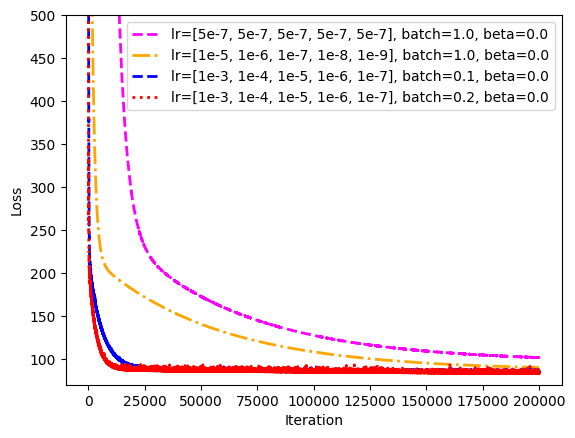

In [24]:
legend_list =  ['lr=[5e-7, 5e-7, 5e-7, 5e-7, 5e-7], batch=1.0, beta=0.0',
                'lr=[1e-5, 1e-6, 1e-7, 1e-8, 1e-9], batch=1.0, beta=0.0',
                'lr=[1e-3, 1e-4, 1e-5, 1e-6, 1e-7], batch=0.1, beta=0.0',
                'lr=[1e-3, 1e-4, 1e-5, 1e-6, 1e-7], batch=0.2, beta=0.0']

plt.plot(losses_1, color='magenta', linestyle='--', linewidth=2)
plt.plot(losses_2, color='orange', linestyle='-.', linewidth=2)
plt.plot(losses_3, color='blue', linestyle='--', linewidth=2)
plt.plot(losses_6, color='red', linestyle=':', linewidth=2)
plt.ylim(70,500)
plt.legend(legend_list)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.savefig('plots/MSE_plot.png')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

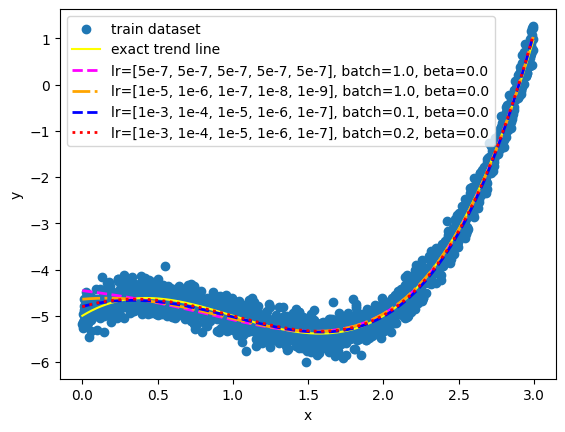

In [25]:
plt.scatter(X_train, y_train)
plt.plot(np.sort(X_train), f_trend(np.sort(X_train)), color='yellow')
plt.plot(np.sort(X_train), f_poly(np.sort(X_train), weights_1), color='magenta', linestyle='--', linewidth=2)
plt.plot(np.sort(X_train), f_poly(np.sort(X_train), weights_2), color='orange', linestyle='-.', linewidth=2)
plt.plot(np.sort(X_train), f_poly(np.sort(X_train), weights_3), color='blue', linestyle='--', linewidth=2)
plt.plot(np.sort(X_train), f_poly(np.sort(X_train), weights_6), color='red', linestyle=':', linewidth=2)
plt.legend(['train dataset', 'exact trend line'] + legend_list)
plt.xlabel('x')
plt.ylabel('y')
plt.savefig('plots/trend_line_plot.png')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

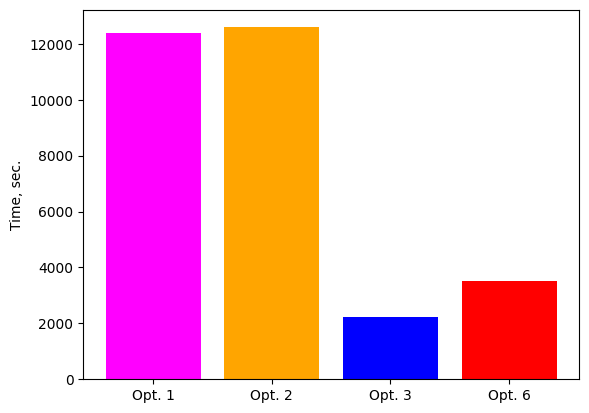

In [26]:
fit_time = [fit_time_1, fit_time_2, fit_time_3, fit_time_6]
bar_label = ['Opt. 1', 'Opt. 2', 'Opt. 3', 'Opt. 6']
bar_colors = ['magenta', 'orange', 'blue', 'red']
plt.bar(bar_label, fit_time, color=bar_colors)
plt.ylabel('Time, sec.')
plt.savefig('plots/time_plot.png')
plt.show

In [27]:
#fit_time = [17800.521367788315, 17925.368300437927, 3114.852860212326, 5091.532459259033]
#fit_time = [12385.795056581497, 12590.523885726929, 2236.7169489860535, 3372.404621362686]
fit_time

[12385.795056581497, 12590.523885726929, 2236.7169489860535, 3503.591392993927]